In [ ]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。


# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
# sys.path.append("/content/drive/MyDrive/Colab Notebooks/ecg-classification")
# from IPython.display import Video

import cv2
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。


from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer


In [ ]:
# reload modules
%load_ext autoreload
%autoreload 2

# print(EcgConfig())

## Data

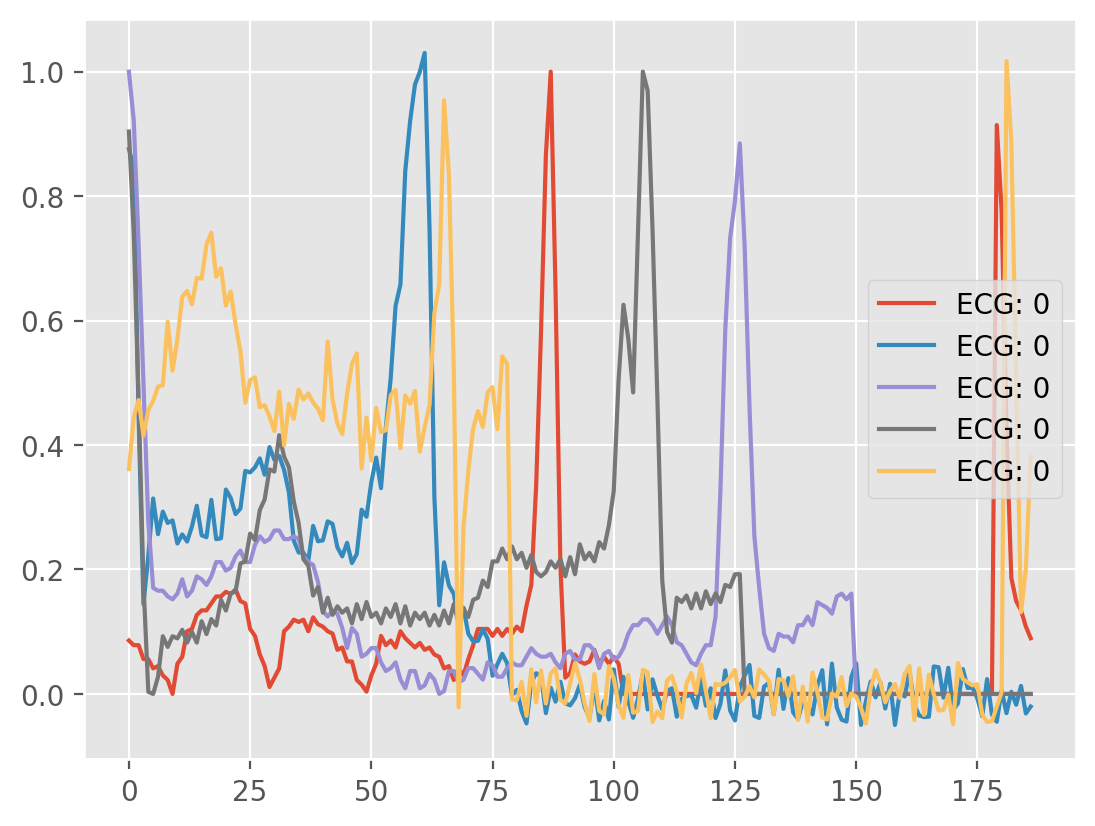

In [ ]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

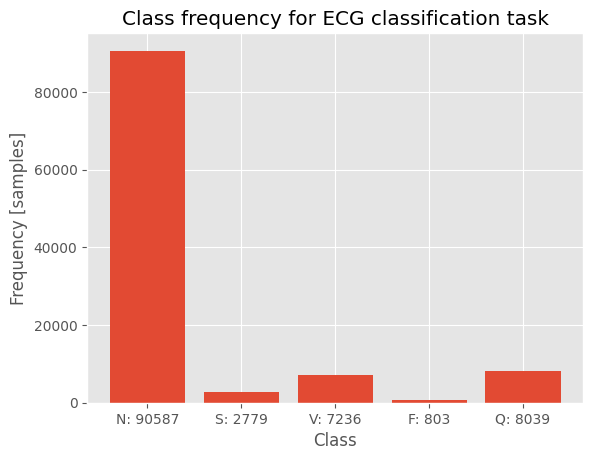

In [ ]:
config = EcgConfig()
data_loaders = get_data_loaders(EcgConfig().dataset)
classes = ["N", "S", "V", "F", "Q"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [ ]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model

from torchinfo import summary
summary(model, input_size=(2, 187, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [2, 187, 1]               [2, 5]                    36,096                    --
├─LinearEmbedding: 1-1                             [2, 187, 1]               [2, 188, 192]             192                       --
│    └─Linear: 2-1                                 [2, 187, 1]               [2, 187, 192]             384                       --
│    └─LayerNorm: 2-2                              [2, 187, 192]             [2, 187, 192]             384                       --
│    └─GELU: 2-3                                   [2, 187, 192]             [2, 187, 192]             --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [2, 188, 192]  

## Training

In [ ]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

TRAINING: 0, loss: 0.28006815910339355. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:08<00:00, 42.68it/s]


TRAINING Accuracy: 0.8899940252304077
[[70236   323   805   220   886]
 [ 1636   467    87     2    31]
 [ 2744    62  2424    62   496]
 [  495     2    19   124     1]
 [ 1482    13   251     1  4684]]
epoch_loss: 5.1172694884595934e-05


VALIDATION: 0, loss: 0.6528359651565552. Target: [4, 4, 4], Prediction: [0, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 106.49it/s]


VALIDATION Accuracy: 0.9341673254966736
[[17435   212   390    12    68]
 [  222   290    41     0     3]
 [  182    16  1237     2    11]
 [   78     0    39    44     1]
 [  129     0    23     0  1456]]


TRAINING: 1, loss: 0.02478969655930996. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:07<00:00, 43.01it/s]


TRAINING Accuracy: 0.9286839962005615
[[70224   570   927   337   412]
 [ 1135   952   115     0    21]
 [ 1242    66  4196   113   171]
 [  336     4    42   259     0]
 [  556    21   161     1  5692]]
epoch_loss: 4.529453053044027e-06


TRAINING: 2, loss: 0.016759665682911873. Target: [2], Prediction: [2]: 100%|██████████| 5473/5473 [02:05<00:00, 43.48it/s]


TRAINING Accuracy: 0.9386876225471497
[[70495   596   753   300   326]
 [  983  1119   104     1    16]
 [ 1025    80  4458    98   127]
 [  265     3    51   322     0]
 [  490    15   121     0  5805]]
epoch_loss: 3.062244780360291e-06


VALIDATION: 2, loss: 0.010143313556909561. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 108.32it/s]


VALIDATION Accuracy: 0.950420081615448
[[17710    81   157   111    58]
 [  233   315     7     0     1]
 [  188    35  1178    39     8]
 [   28     0    10   123     1]
 [   99     0    17     0  1492]]


TRAINING: 3, loss: 0.008502237498760223. Target: [1], Prediction: [1]: 100%|██████████| 5473/5473 [02:04<00:00, 43.97it/s]


TRAINING Accuracy: 0.9425817131996155
[[70592   549   706   299   324]
 [  906  1217    85     0    15]
 [  920    83  4556   104   125]
 [  247     1    58   334     1]
 [  477    10   102     1  5841]]
epoch_loss: 1.5534875751434723e-06


TRAINING: 4, loss: 1.8954096958623268e-05. Target: [4], Prediction: [4]: 100%|██████████| 5473/5473 [02:04<00:00, 43.96it/s]


TRAINING Accuracy: 0.9449228048324585
[[70592   575   684   292   327]
 [  874  1245    87     2    15]
 [  883    73  4640    95    97]
 [  240     3    37   360     1]
 [  417    12    94     0  5908]]
epoch_loss: 3.463200613671344e-09


VALIDATION: 4, loss: 0.0407058522105217. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 108.62it/s]


VALIDATION Accuracy: 0.9629748463630676
[[17961    34    55    35    32]
 [  231   316     8     0     1]
 [  165    12  1194    55    22]
 [   37     0     5   119     1]
 [   99     0     6     0  1503]]


TRAINING: 5, loss: 0.005526383873075247. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:04<00:00, 43.83it/s]


TRAINING Accuracy: 0.9470126032829285
[[70651   585   644   287   303]
 [  826  1294    86     5    12]
 [  847    78  4668    96    99]
 [  226     2    46   367     0]
 [  380    14    89     0  5948]]
epoch_loss: 1.0097540422209477e-06


TRAINING: 6, loss: 0.01567002385854721. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:03<00:00, 44.49it/s]


TRAINING Accuracy: 0.9487940669059753
[[70714   590   623   260   283]
 [  814  1313    80     1    15]
 [  822    80  4706    86    94]
 [  211     2    51   376     1]
 [  376     9    71     0  5975]]
epoch_loss: 2.8631507141507783e-06


VALIDATION: 6, loss: 0.007425225805491209. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 112.66it/s]


VALIDATION Accuracy: 0.9586377143859863
[[17762   194    76    63    22]
 [  183   368     4     0     1]
 [  136    37  1229    38     8]
 [   27     1     7   126     1]
 [   87     0     8     0  1513]]


TRAINING: 7, loss: 0.04228447005152702. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:58<00:00, 46.17it/s]


TRAINING Accuracy: 0.9493992924690247
[[70718   541   666   268   277]
 [  782  1347    82     4     8]
 [  812    90  4691    97    98]
 [  196     2    52   391     0]
 [  355    11    75     0  5990]]
epoch_loss: 7.726013164905357e-06


TRAINING: 8, loss: 0.0841066986322403. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:57<00:00, 46.54it/s]


TRAINING Accuracy: 0.9494792222976685
[[70676   593   655   256   290]
 [  794  1343    73     1    12]
 [  792    76  4753    84    83]
 [  196     4    46   395     0]
 [  379     7    68     0  5977]]
epoch_loss: 1.5367567811481875e-05


VALIDATION: 8, loss: 0.013328193686902523. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 112.82it/s]


VALIDATION Accuracy: 0.9491873979568481
[[17572   434    83    16    12]
 [  161   390     4     0     1]
 [  144    29  1227    39     9]
 [   45     1     7   109     0]
 [  110     0     5     0  1493]]


TRAINING: 9, loss: 0.10400503128767014. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 46.93it/s]


TRAINING Accuracy: 0.9505983591079712
[[70758   571   600   261   280]
 [  773  1355    80     1    14]
 [  795    66  4764    81    82]
 [  203     3    40   395     0]
 [  371     8    82     0  5970]]
epoch_loss: 1.9003294589378794e-05


TRAINING: 10, loss: 0.03576497733592987. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 46.95it/s]


TRAINING Accuracy: 0.9507468342781067
[[70735   554   651   254   276]
 [  759  1361    86     2    15]
 [  792    72  4777    76    71]
 [  195     8    44   394     0]
 [  369    10    63     1  5988]]
epoch_loss: 6.534803094450917e-06


VALIDATION: 10, loss: 0.014603537507355213. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 113.42it/s]


VALIDATION Accuracy: 0.967220664024353
[[17973    42    84     7    11]
 [  205   337    14     0     0]
 [  143     5  1261    34     5]
 [   52     0     9   101     0]
 [   84     0    10     0  1514]]


TRAINING: 11, loss: 0.24810558557510376. Target: [1], Prediction: [1]: 100%|██████████| 5473/5473 [01:56<00:00, 47.00it/s]


TRAINING Accuracy: 0.9531335234642029
[[70826   541   626   234   243]
 [  729  1414    72     0     8]
 [  773    49  4805    87    74]
 [  200     2    48   391     0]
 [  327     8    67     1  6028]]
epoch_loss: 4.5332648561137174e-05


TRAINING: 12, loss: 0.014737079851329327. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:57<00:00, 46.68it/s]


TRAINING Accuracy: 0.9529851078987122
[[70826   550   579   240   275]
 [  737  1404    68     3    11]
 [  736    63  4830    77    82]
 [  186     2    52   400     1]
 [  353    11    76     0  5991]]
epoch_loss: 2.6926877126492465e-06


VALIDATION: 12, loss: 0.009416886605322361. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 112.51it/s]


VALIDATION Accuracy: 0.9647096991539001
[[17918    82    65    31    21]
 [  191   358     7     0     0]
 [  143     9  1249    44     3]
 [   44     0     7   111     0]
 [  103     1     9     0  1495]]


TRAINING: 13, loss: 0.05794356390833855. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 47.12it/s]


TRAINING Accuracy: 0.9523912668228149
[[70753   595   582   258   282]
 [  740  1416    55     2    10]
 [  727    68  4834    74    85]
 [  187     5    42   406     1]
 [  358     8    75     0  5990]]
epoch_loss: 1.0587166802181353e-05


TRAINING: 14, loss: 0.0033889738842844963. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 47.04it/s]


TRAINING Accuracy: 0.9516603946685791
[[70761   573   601   265   270]
 [  713  1423    69     2    16]
 [  774    80  4778    78    78]
 [  206     1    48   386     0]
 [  362    10    72     0  5987]]
epoch_loss: 6.192168617366154e-07


VALIDATION: 14, loss: 0.02559918537735939. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 113.71it/s]


VALIDATION Accuracy: 0.9639792442321777
[[17950    58    65    21    23]
 [  209   341     5     0     1]
 [  149    28  1215    44    12]
 [   47     0     5   110     0]
 [  104     2     3     0  1499]]


TRAINING: 15, loss: 0.02795812115073204. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 47.08it/s]


TRAINING Accuracy: 0.9518431425094604
[[70784   602   588   244   252]
 [  744  1395    69     2    13]
 [  749    68  4782    96    93]
 [  198     2    42   399     0]
 [  343    14    83     0  5991]]
epoch_loss: 5.108372218295641e-06


TRAINING: 16, loss: 0.20672893524169922. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:56<00:00, 47.10it/s]


TRAINING Accuracy: 0.9519915580749512
[[70727   597   617   259   270]
 [  733  1417    60     0    13]
 [  763    67  4808    83    67]
 [  193     5    38   405     0]
 [  350     8    66     0  6007]]
epoch_loss: 3.7772507809555856e-05


VALIDATION: 16, loss: 0.0006057990249246359. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 113.87it/s]


VALIDATION Accuracy: 0.9637966156005859
[[17879    52    71    67    48]
 [  200   348     5     1     2]
 [  145    26  1235    31    11]
 [   29     0     9   124     0]
 [   76     0     7     0  1525]]


TRAINING: 17, loss: 0.07657478749752045. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:55<00:00, 47.48it/s]


TRAINING Accuracy: 0.9508267641067505
[[70714   568   631   269   288]
 [  766  1393    54     0    10]
 [  795    67  4760    88    78]
 [  179     5    43   414     0]
 [  378     6    66     0  5981]]
epoch_loss: 1.3991373560665164e-05


TRAINING: 18, loss: 0.00405014818534255. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:54<00:00, 47.60it/s]


TRAINING Accuracy: 0.9518088698387146
[[70725   574   653   265   253]
 [  738  1409    65     3     8]
 [  716    73  4834    78    87]
 [  188     2    54   397     0]
 [  362     8    77     1  5983]]
epoch_loss: 7.400234214037183e-07


VALIDATION: 18, loss: 0.0183887779712677. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 112.23it/s]


VALIDATION Accuracy: 0.9600529670715332
[[17814   180    60    18    45]
 [  184   366     5     0     1]
 [  170     9  1219    26    24]
 [   47     0    11   104     0]
 [   78     0     4     0  1526]]


TRAINING: 19, loss: 0.007284154184162617. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:54<00:00, 47.63it/s]


TRAINING Accuracy: 0.9515919089317322
[[70736   610   661   224   239]
 [  757  1384    67     3    12]
 [  727    60  4808    95    98]
 [  175     4    48   414     0]
 [  355     7    81     1  5987]]
epoch_loss: 1.3309253031541416e-06


TRAINING: 20, loss: 0.1268293410539627. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:54<00:00, 47.68it/s]


TRAINING Accuracy: 0.9521628618240356
[[70762   574   633   232   269]
 [  727  1417    61     3    15]
 [  771    63  4791    80    83]
 [  179     5    42   414     1]
 [  353     7    75     1  5995]]
epoch_loss: 2.317364170545637e-05


VALIDATION: 20, loss: 0.12218105047941208. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:11<00:00, 114.23it/s]


VALIDATION Accuracy: 0.9629748463630676
[[17797   104   165    30    21]
 [  180   358    17     1     0]
 [   81    11  1329    23     4]
 [   37     0    18   107     0]
 [   87     1    18     0  1502]]


TRAINING: 21, loss: 0.047327883541584015. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:55<00:00, 47.46it/s]


TRAINING Accuracy: 0.9516375660896301
[[70723   614   588   261   284]
 [  743  1409    56     1    14]
 [  751    61  4804    80    92]
 [  184     2    40   415     0]
 [  353     5    90     1  5982]]
epoch_loss: 8.64752120255509e-06


TRAINING: 22, loss: 1.2550382614135742. Target: [2], Prediction: [0]: 100%|██████████| 5473/5473 [01:55<00:00, 47.44it/s]


TRAINING Accuracy: 0.9523227214813232
[[70733   608   604   257   268]
 [  739  1410    61     1    12]
 [  724    64  4821    84    95]
 [  175     3    37   425     1]
 [  332     7    86     2  6004]]
epoch_loss: 0.00022931450053235414


VALIDATION: 22, loss: 0.0063054561614990234. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 113.73it/s]


VALIDATION Accuracy: 0.9564006924629211
[[17587   173   172   100    85]
 [  161   374    18     1     2]
 [   79     7  1311    33    18]
 [   25     1     8   127     1]
 [   54     0     4     0  1550]]


TRAINING: 23, loss: 2.8437695503234863. Target: [1], Prediction: [0]: 100%|██████████| 5473/5473 [01:54<00:00, 47.70it/s]


TRAINING Accuracy: 0.9511008262634277
[[70703   554   629   285   299]
 [  762  1390    62     0     9]
 [  751    58  4811    79    89]
 [  192     2    42   405     0]
 [  367     6    80     1  5977]]
epoch_loss: 0.000519599771665172


TRAINING: 24, loss: 0.007245100103318691. Target: [4], Prediction: [4]: 100%|██████████| 5473/5473 [01:54<00:00, 47.70it/s]


TRAINING Accuracy: 0.9542754888534546
[[70846   538   587   260   239]
 [  725  1418    67     4     9]
 [  684    61  4872    86    85]
 [  176     1    51   413     0]
 [  326    15    75     0  6015]]
epoch_loss: 1.3237895310284471e-06


VALIDATION: 24, loss: 0.0027776043862104416. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:11<00:00, 114.10it/s]


VALIDATION Accuracy: 0.9654401540756226
[[17891    75    63    32    56]
 [  190   357     5     2     2]
 [  141    19  1245    31    12]
 [   33     0     9   120     0]
 [   67     0     7     0  1534]]


TRAINING: 25, loss: 0.009309454821050167. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [01:54<00:00, 47.81it/s]


TRAINING Accuracy: 0.9545381665229797
[[70818   567   572   271   242]
 [  692  1458    58     3    12]
 [  697    67  4863    85    76]
 [  176     1    45   418     1]
 [  319     5    77     0  6030]]
epoch_loss: 1.7009784069157988e-06


TRAINING: 26, loss: 0.0016087458934634924. Target: [2], Prediction: [2]: 100%|██████████| 5473/5473 [01:55<00:00, 47.29it/s]


TRAINING Accuracy: 0.9528480768203735
[[70741   594   635   251   249]
 [  711  1446    55     2     9]
 [  724    67  4829    79    89]
 [  184     3    37   417     0]
 [  346     8    71     0  6006]]
epoch_loss: 2.9394224254768725e-07


VALIDATION: 26, loss: 0.004012306686490774. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 108.54it/s]


VALIDATION Accuracy: 0.9648922681808472
[[17819   146    80    38    34]
 [  169   378     6     2     1]
 [  122     9  1290    19     8]
 [   27     0    17   118     0]
 [   68     0    10     0  1530]]


TRAINING: 27, loss: 0.0534670427441597. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:03<00:00, 44.39it/s]


TRAINING Accuracy: 0.9553604125976562
[[70798   548   577   289   258]
 [  668  1486    58     1    10]
 [  674    57  4901    86    70]
 [  169     3    44   425     0]
 [  304    10    68     0  6049]]
epoch_loss: 9.769238579236195e-06


TRAINING: 28, loss: 0.022503722459077835. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:00<00:00, 45.54it/s]


TRAINING Accuracy: 0.955132007598877
[[70831   543   591   256   249]
 [  697  1466    47     4     9]
 [  676    70  4886    80    76]
 [  170     3    41   427     0]
 [  322     8    72     0  6029]]
epoch_loss: 4.1117709590860284e-06


VALIDATION: 28, loss: 0.08177085965871811. Target: [4, 4, 4], Prediction: [4, 4, 4]: 100%|██████████| 1369/1369 [00:12<00:00, 108.68it/s]


VALIDATION Accuracy: 0.9612399935722351
[[17747   183   107    17    63]
 [  168   376    11     0     1]
 [  100    10  1303    25    10]
 [   43     0    13   106     0]
 [   74     1    10     0  1523]]


TRAINING: 29, loss: 0.008940782397985458. Target: [0], Prediction: [0]: 100%|██████████| 5473/5473 [02:01<00:00, 45.16it/s]


TRAINING Accuracy: 0.9547094702720642
[[70787   564   582   265   272]
 [  700  1454    55     4    10]
 [  655    58  4911    82    82]
 [  181     1    36   422     1]
 [  327    13    62     1  6028]]
epoch_loss: 1.6336163709090917e-06


## Evaluating

In [ ]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

NameError: name 'plt' is not defined

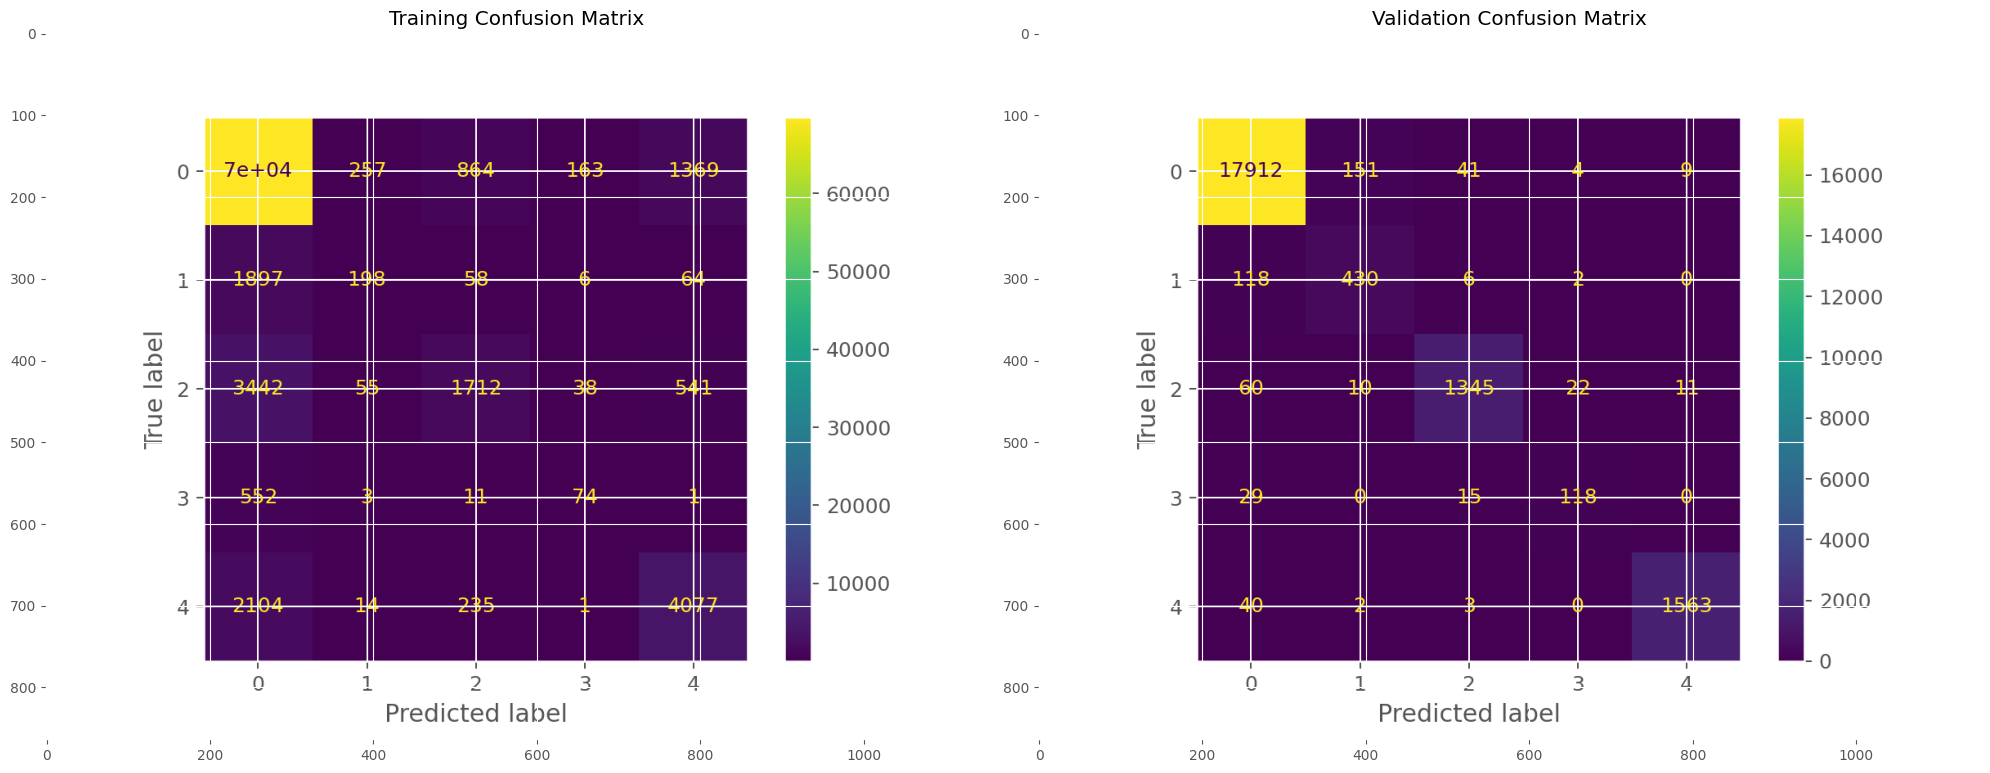

In [ ]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


### Save model and load model

In [ ]:
import torch
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/ECG-Classification/model.pth")
model_test = torch.load("/content/drive/MyDrive/Colab Notebooks/ECG-Classification/model.pth")
print(model_test)

ECGformer(
  (encoder): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):